In [33]:
import gymnasium as gym
from minigrid.wrappers import ImgObsWrapper, FullyObsWrapper
from stable_baselines3.common.monitor import Monitor
from stable_baselines3.common.vec_env import DummyVecEnv, VecVideoRecorder
import numpy as np
import matplotlib.pyplot as plt
import torch
import os
from stable_baselines3 import PPO
from cnn import MinigridFeaturesExtractor
from stable_baselines3.common.utils import obs_as_tensor

In [32]:
# For 5 by 5 fully observable minigrid
config = {
    "policy_type": "CnnPolicy",
    "total_timesteps": 2e5,
    "env_name": "MiniGrid-Empty-5x5-v0",
    "feat_dim":32,
}

# For 16 by 16 minigrid
# config = {
#     "policy_type": "CnnPolicy",
#     "total_timesteps": 2e5,
#     "env_name": "MiniGrid-Empty-16x16-v0",
#     "feat_dim":128,
# }

In [18]:
# load agent
# model = PPO.load("models/lmqa7hgs/model.zip") # 16by16 empty
# model = PPO.load("models/ymxb53rz/model.zip") # 16by16 empty run 2
# model = PPO.load("models/41p5gtap/model.zip") # 5by5 empty feat vec = 128
model = PPO.load("/Users/kevinroice/Documents/research/discovery/models/fmayv5p9/model")

In [21]:
def make_env():
    env = gym.make(config["env_name"], render_mode="rgb_array")
    env = FullyObsWrapper(env)
    env = ImgObsWrapper(env)
    env = Monitor(env)
    return env

def pre_process_obs(obs, model):
    obs = np.transpose(obs, (0,3,1,2)) # bring colour channel to front
    return obs_as_tensor(obs, model.policy.device)

In [23]:
env = DummyVecEnv([make_env])
obs = env.reset()

In [24]:
def get_all_possible_obs(env, see_obs=False):
    obs = env.reset()
    # obs_list = [obs]
    obs_list = []
    for i in range(3):
        for j in range(3):
            for k in range(4):
                obs, _, _, _ = env.step([1])
                img = env.render()
                obs_list.append(obs)
                if see_obs:
                    plt.imshow(np.concatenate([img], 1)) # shows the full environment
                    plt.show()
            obs, _, _, _ = env.step([2])
            # obs_list.append(obs)
        env.reset()
        obs, _, _, _ = env.step([1])
        for down in range(i+1): # go to next row
            obs, _, _, _ = env.step([2])
        obs, _, _, _ = env.step([0])
    return obs_list

In [26]:
obs_list = get_all_possible_obs(env, see_obs=False)
max_feat_list = []
feature_activations = []

with torch.no_grad():
    for obs in obs_list:
        obs = pre_process_obs(obs, model)
        x = model.policy.extract_features(obs)
        max_feat_list.append(torch.argmax(x).item())
        feature_activations.append(x.reshape(1, -1))

feature_activations = torch.cat(feature_activations, dim=0)

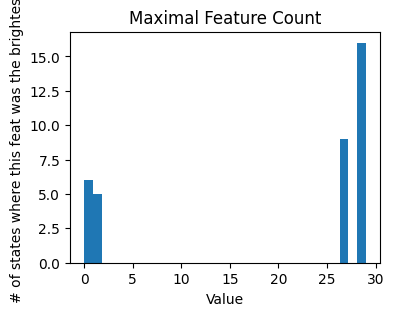

In [36]:
plt.figure(figsize=(4, 3))
plt.hist(max_feat_list, bins=config["feat_dim"])
plt.xlabel('Value')
plt.ylabel('# of states where this feat was the brightest')
plt.title('Maximal Feature Count')
plt.show()

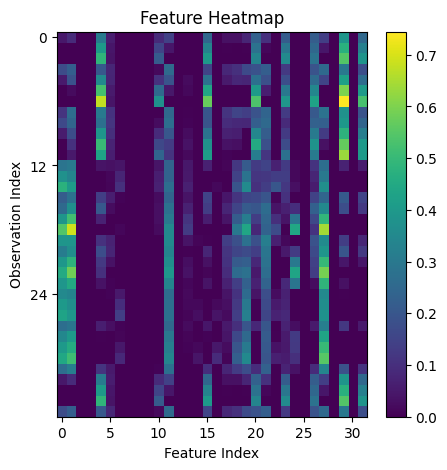

In [30]:
plt.figure(figsize=(5, 5))  # Adjust the figure size as needed
plt.imshow(feature_activations, cmap='viridis', aspect='auto')
# y_tick_positions = [i * 56 for i in range(785 // 56)] # 16 by 16
y_tick_positions = [i * 12 for i in range(36 // 12)]
plt.yticks(y_tick_positions)
plt.colorbar()
plt.xlabel('Feature Index')
plt.ylabel('Observation Index')
plt.title('Feature Heatmap')
plt.show()